In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# modeling imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

from mlxtend.classifier import StackingClassifier
import xgboost as xgb


In [2]:
with open('./Data/cleaned_dataframe.pickle','rb') as read_file:
    df = pickle.load(read_file)

In [3]:
# Create numerical categories for fitness category (needed for metrics analysis).

df["low_fitness"] = np.where(df["fitness_category"] == "Low", 1, 0)

In [4]:
# Create a function for assisting with model selection.

# Graphs the metrics from a dictionary of models.

def model_score_visual(models):
    """
    Output
    Graphs the different scores for a classification model.
    
    Input
    model: models of interest passed as a dictionary.
    The keys are used as labels in the graphs.
    The values are a list with the featuers, y, and decision threshold for the model.
    """
    
    # Get the scores for each model
    accuracy, precision, recall, f1, roc_auc = [], [], [], [], []
    
    for lst in models.values():
        mod, features, y, *threshold = lst
        
        if threshold:
            y_predict = (mod.predict_proba(features)[:, 1] >= threshold)
        else:
            y_predict = mod.predict(features)

        accuracy.append(round(100*accuracy_score(y, y_predict),1))
        precision.append(round(100*precision_score(y, y_predict),1))
        recall.append(round(100*recall_score(y, y_predict),1))
        f1.append(round(100*f1_score(y, y_predict),1))
        roc_auc.append(round(100*roc_auc_score(y, y_predict),1))
        
    names = [*models]
    
    fig = plt.figure(figsize = (16,8))
    plt.style.use("default")

    plt.subplot(2,3,1)
    plt.bar(names, accuracy, color=["lightblue"])
    plt.title("Accuracy Scores", weight="bold")
    plt.ylim([0,100])
    for i,v in enumerate(accuracy):
        plt.text(i, v-5, str(v), ha = "center", color='k', fontweight='bold')

    plt.subplot(2,3,2)
    plt.bar(names, precision, color=["skyblue"])
    plt.title("Precision Scores", weight="bold")
    plt.ylim([0,100])
    for i,v in enumerate(precision):
        plt.text(i, v-5, str(v), ha = "center", color='k', fontweight='bold')
        
    plt.subplot(2,3,3)
    plt.bar(names, recall, color=["firebrick"])
    plt.title("Recall Scores", weight="bold")
    plt.ylim([0,100])
    for i,v in enumerate(recall):
        plt.text(i, v-5, str(v), ha = "center", color='white', fontweight='bold')
        
    plt.subplot(2,3,4)
    plt.bar(names, f1, color=["paleturquoise"])
    plt.title("F1 Scores", weight="bold")
    plt.ylim([0,100])
    for i,v in enumerate(f1):
        plt.text(i, v-5, str(v), ha = "center", color='k', fontweight='bold')
        
    plt.subplot(2,3,5)
    plt.bar(names, roc_auc, color=["cadetblue"])
    plt.title("ROC AUC Scores", weight="bold")
    plt.ylim([0,100])
    plt.axhline(y = 50, linestyle = "dashed", color = "k")
    for i,v in enumerate(roc_auc):
        plt.text(i, v-5, str(v), ha = "center", color='k', fontweight='bold')
    
    return plt

## Try different features in the models.

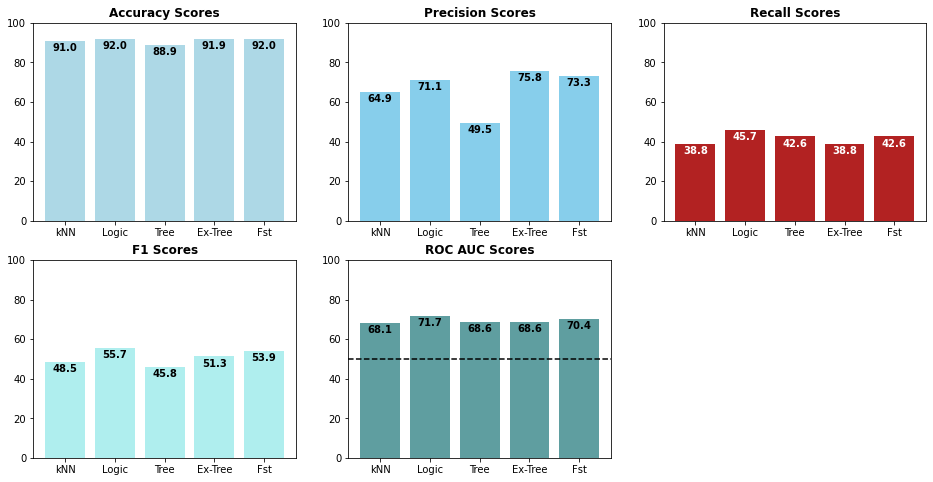

In [5]:
# Try with body fat as feature (basically all features).
# (body fat is missing for some though so filter to no nan).

df_bf = df.dropna(subset=["bodyfat"])

X = df_bf[["ageattest", "Gender", "bmi", "bodyfat",
        "PhysInactive", "resting_hr", "resting_sbp",
        "BetaMed", "hypertension",
       "Diabetes", "COPD", "ANYCVD", "Asthma"]]
y = df_bf["low_fitness"]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=13)

X_train_val = pd.get_dummies(X_train_val, drop_first=True)
X_train = pd.get_dummies(X_train, drop_first=True)
X_val = pd.get_dummies(X_val, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

std_scale = StandardScaler()
X_train_val_scaled = std_scale.fit_transform(X_train_val)
X_train_scaled = std_scale.fit_transform(X_train)
X_val_scaled = std_scale.fit_transform(X_val)
X_test_scaled = std_scale.fit_transform(X_test)

# Train the models.
knn = KNeighborsClassifier(n_neighbors=5)
log_reg = LogisticRegression()
d_tree = DecisionTreeClassifier()
ex_tree = ExtraTreesClassifier(n_estimators=50)
rand_forest = RandomForestClassifier(n_estimators=50)

# Fit the models.
knn.fit(X_train_scaled, y_train)
log_reg.fit(X_train_scaled, y_train)
d_tree.fit(X_train, y_train)
ex_tree.fit(X_train, y_train)
rand_forest.fit(X_train, y_train)

# Test the models on validations.
model_dct = {
    "kNN": [knn, X_val_scaled, y_val],
    "Logic": [log_reg, X_val_scaled, y_val],
    "Tree": [d_tree, X_val, y_val],
    "Ex-Tree": [ex_tree, X_val, y_val],
    "Fst": [rand_forest, X_val, y_val]
}

model_score_visual(model_dct);

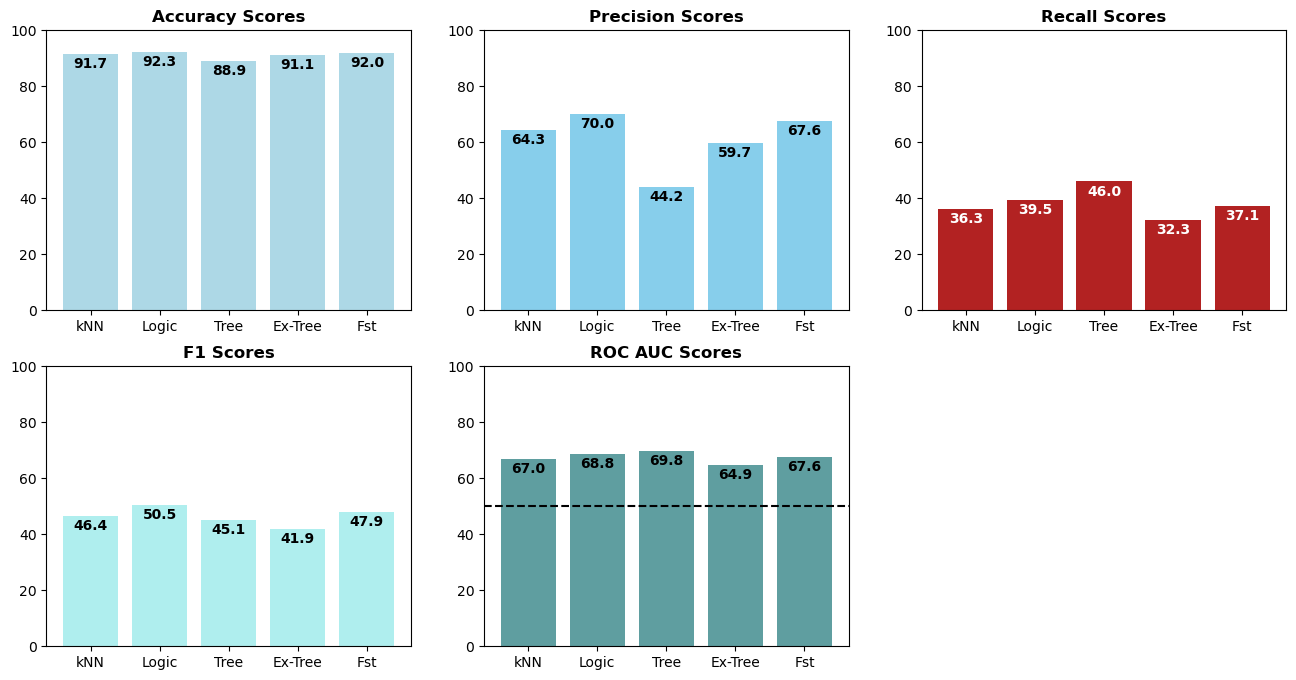

In [6]:
# Try WITHOUT body fat as feature since it's not commonly assessed.

X = df[["ageattest", "Gender", "bmi",
        "PhysInactive", "resting_hr", "resting_sbp",
        "BetaMed", "hypertension",
       "Diabetes", "COPD", "ANYCVD", "Asthma"]]
y = df["low_fitness"]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=13)

X_train_val = pd.get_dummies(X_train_val, drop_first=True)
X_train = pd.get_dummies(X_train, drop_first=True)
X_val = pd.get_dummies(X_val, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

std_scale = StandardScaler()
X_train_val_scaled = std_scale.fit_transform(X_train_val)
X_train_scaled = std_scale.fit_transform(X_train)
X_val_scaled = std_scale.fit_transform(X_val)
X_test_scaled = std_scale.fit_transform(X_test)

# Train the models.
knn = KNeighborsClassifier(n_neighbors=5)
log_reg = LogisticRegression()
d_tree = DecisionTreeClassifier()
ex_tree = ExtraTreesClassifier(n_estimators=50)
rand_forest = RandomForestClassifier(n_estimators=50)

# Fit the models.
knn.fit(X_train_scaled, y_train)
log_reg.fit(X_train_scaled, y_train)
d_tree.fit(X_train, y_train)
ex_tree.fit(X_train, y_train)
rand_forest.fit(X_train, y_train)

# Test the models on validations.
model_dct = {
    "kNN": [knn, X_val_scaled, y_val],
    "Logic": [log_reg, X_val_scaled, y_val],
    "Tree": [d_tree, X_val, y_val],
    "Ex-Tree": [ex_tree, X_val, y_val],
    "Fst": [rand_forest, X_val, y_val]
}

model_score_visual(model_dct);

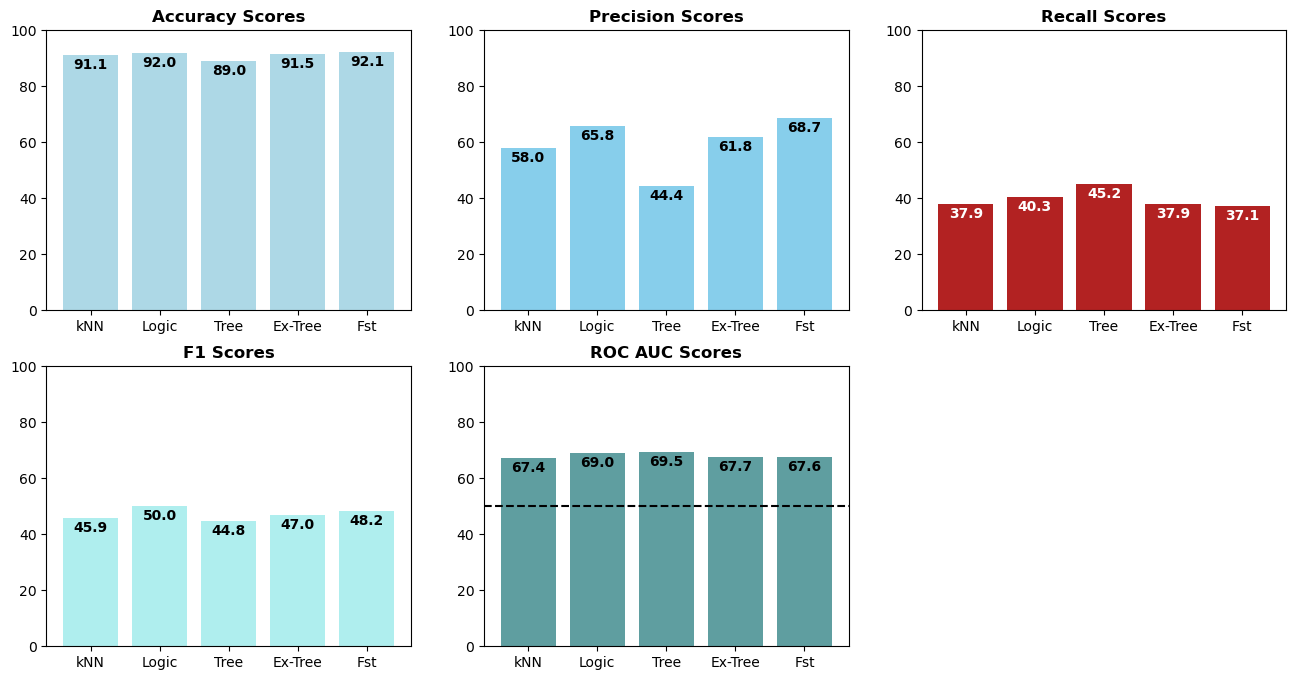

In [7]:
# Try WITHOUT having to measure any features (ie, no HR or BP).

X = df[["ageattest", "Gender", "height", "weight",
        "PhysInactive", 
        "BetaMed", "hypertension",
       "Diabetes", "COPD", "ANYCVD", "Asthma"]]
y = df["low_fitness"]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=13)

X_train_val = pd.get_dummies(X_train_val, drop_first=True)
X_train = pd.get_dummies(X_train, drop_first=True)
X_val = pd.get_dummies(X_val, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

std_scale = StandardScaler()
X_train_val_scaled = std_scale.fit_transform(X_train_val)
X_train_scaled = std_scale.fit_transform(X_train)
X_val_scaled = std_scale.fit_transform(X_val)
X_test_scaled = std_scale.fit_transform(X_test)

# Train the models.
knn = KNeighborsClassifier(n_neighbors=5)
log_reg = LogisticRegression()
d_tree = DecisionTreeClassifier()
ex_tree = ExtraTreesClassifier(n_estimators=50)
rand_forest = RandomForestClassifier(n_estimators=50)

# Fit the models.
knn.fit(X_train_scaled, y_train)
log_reg.fit(X_train_scaled, y_train)
d_tree.fit(X_train, y_train)
ex_tree.fit(X_train, y_train)
rand_forest.fit(X_train, y_train)

# Test the models on validations.
model_dct = {
    "kNN": [knn, X_val_scaled, y_val],
    "Logic": [log_reg, X_val_scaled, y_val],
    "Tree": [d_tree, X_val, y_val],
    "Ex-Tree": [ex_tree, X_val, y_val],
    "Fst": [rand_forest, X_val, y_val]
}

model_score_visual(model_dct);

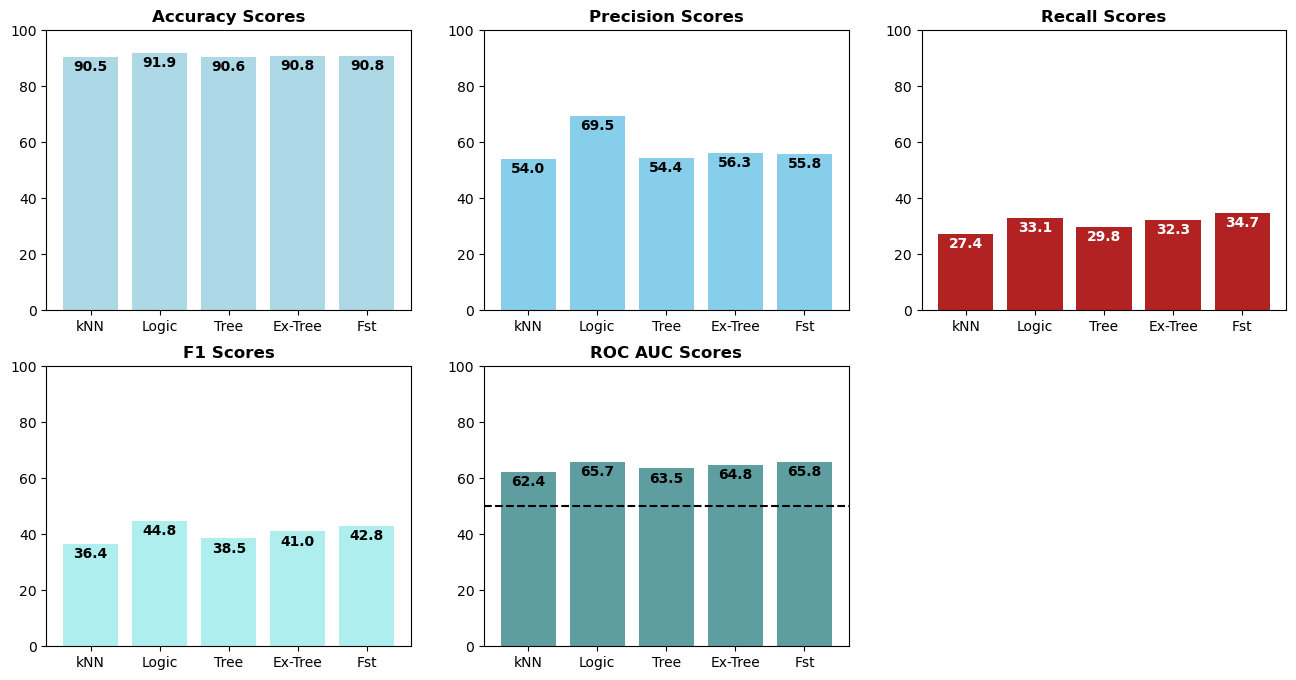

In [8]:
# Try WITHOUT having to measure any features but use BMI category.

X = df[["ageattest", "Gender", "bmi_cat",
        "PhysInactive", 
        "BetaMed", "hypertension",
       "Diabetes", "COPD", "ANYCVD", "Asthma"]]
y = df["low_fitness"]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=13)

X_train_val = pd.get_dummies(X_train_val, drop_first=True)
X_train = pd.get_dummies(X_train, drop_first=True)
X_val = pd.get_dummies(X_val, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

std_scale = StandardScaler()
X_train_val_scaled = std_scale.fit_transform(X_train_val)
X_train_scaled = std_scale.fit_transform(X_train)
X_val_scaled = std_scale.fit_transform(X_val)
X_test_scaled = std_scale.fit_transform(X_test)

# Train the models.
knn = KNeighborsClassifier(n_neighbors=5)
log_reg = LogisticRegression()
d_tree = DecisionTreeClassifier()
ex_tree = ExtraTreesClassifier(n_estimators=50)
rand_forest = RandomForestClassifier(n_estimators=50)

# Fit the models.
knn.fit(X_train_scaled, y_train)
log_reg.fit(X_train_scaled, y_train)
d_tree.fit(X_train, y_train)
ex_tree.fit(X_train, y_train)
rand_forest.fit(X_train, y_train)

# Test the models on validations.
model_dct = {
    "kNN": [knn, X_val_scaled, y_val],
    "Logic": [log_reg, X_val_scaled, y_val],
    "Tree": [d_tree, X_val, y_val],
    "Ex-Tree": [ex_tree, X_val, y_val],
    "Fst": [rand_forest, X_val, y_val]
}

model_score_visual(model_dct);

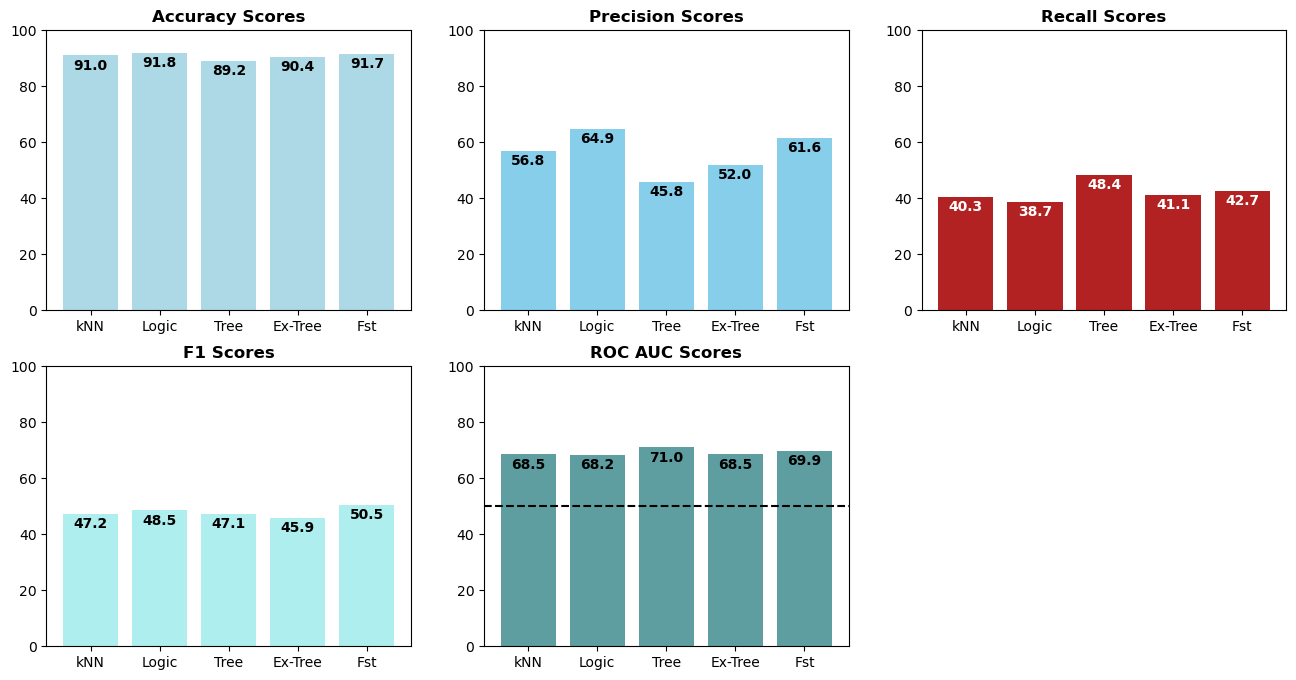

In [9]:
# Try WITHOUT having to measure any features BUT do calculate BMI.

X = df[["ageattest", "Gender", "bmi",
        "PhysInactive", 
        "BetaMed", "hypertension",
       "Diabetes", "COPD", "ANYCVD", "Asthma"]]
y = df["low_fitness"]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=13)

X_train_val = pd.get_dummies(X_train_val, drop_first=True)
X_train = pd.get_dummies(X_train, drop_first=True)
X_val = pd.get_dummies(X_val, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

std_scale = StandardScaler()
X_train_val_scaled = std_scale.fit_transform(X_train_val)
X_train_scaled = std_scale.fit_transform(X_train)
X_val_scaled = std_scale.fit_transform(X_val)
X_test_scaled = std_scale.fit_transform(X_test)

# Train the models.
knn = KNeighborsClassifier(n_neighbors=5)
log_reg = LogisticRegression()
d_tree = DecisionTreeClassifier()
ex_tree = ExtraTreesClassifier(n_estimators=50)
rand_forest = RandomForestClassifier(n_estimators=50)

# Fit the models.
knn.fit(X_train_scaled, y_train)
log_reg.fit(X_train_scaled, y_train)
d_tree.fit(X_train, y_train)
ex_tree.fit(X_train, y_train)
rand_forest.fit(X_train, y_train)

# Test the models on validations.
model_dct = {
    "kNN": [knn, X_val_scaled, y_val],
    "Logic": [log_reg, X_val_scaled, y_val],
    "Tree": [d_tree, X_val, y_val],
    "Ex-Tree": [ex_tree, X_val, y_val],
    "Fst": [rand_forest, X_val, y_val]
}

model_score_visual(model_dct);

## Based on above results (and ease of implementation), going with features that can be self-reported.

Features are: age, sex, height, weight, physical activity status, hypertension status, diabetes status, COPD status, CVD status, asthma status, and beta-blocker medication status.

In [10]:
# These are the final features to be used:

X = df[["ageattest", "Gender", "height", "weight",
        "PhysInactive", 
        "BetaMed", "hypertension",
       "Diabetes", "COPD", "ANYCVD", "Asthma"]]
y = df["low_fitness"]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=13)

X_train_val = pd.get_dummies(X_train_val, drop_first=True)
X_train = pd.get_dummies(X_train, drop_first=True)
X_val = pd.get_dummies(X_val, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

std_scale = StandardScaler()
X_train_val_scaled = std_scale.fit_transform(X_train_val)
X_train_scaled = std_scale.fit_transform(X_train)
X_val_scaled = std_scale.fit_transform(X_val)
X_test_scaled = std_scale.fit_transform(X_test)

## Try Oversampling procedure.

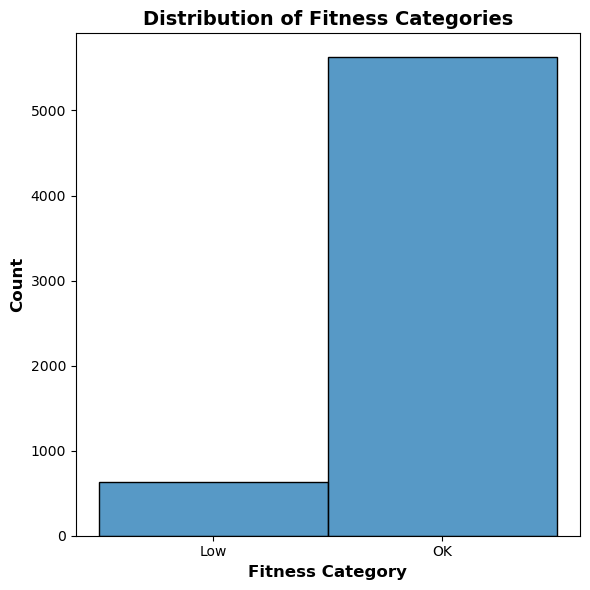

In [11]:
plt.figure(figsize=(6,6))

sns.histplot(data=df, x="fitness_category")
plt.style.use("fast")
plt.title("Distribution of Fitness Categories", weight="bold", size=14)
plt.xlabel("Fitness Category", weight="bold", size=12)
plt.ylabel("Count", weight="bold", size=12)

plt.tight_layout()
plt.savefig("./Figures/target_distribution.jpg");

In [12]:
print(f"The low fitness group makes up {sum(y_train == 1) / (len(y_train))*100:.1f}% of the training dataset.")

The low fitness group makes up 10.1% of the training dataset.


In [13]:
import imblearn.over_sampling

# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {1 : n_pos * 5, 0 : n_neg} 

# randomly oversample positive samples: create 4x as many 
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=31) 
    
X_tr_rs, y_tr_rs = ROS.fit_resample(X_train, y_train)

X_tr_rs_scaled = std_scale.fit_transform(X_tr_rs)

In [14]:
print("With oversampling,")
print(f"The low fitness group makes up {sum(y_tr_rs == 1) / (len(y_tr_rs))*100:.1f}% of the training dataset.")

With oversampling,
The low fitness group makes up 36.1% of the training dataset.


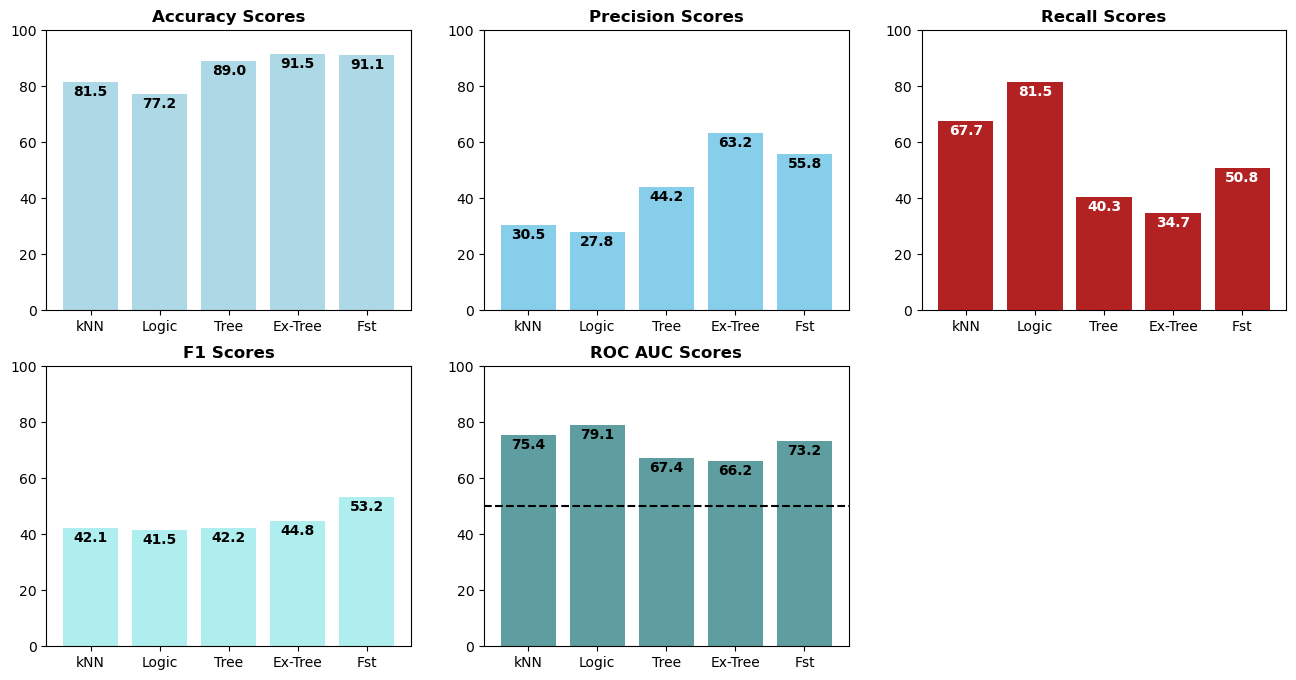

In [15]:
knn = KNeighborsClassifier(n_neighbors=5)
log_reg = LogisticRegression()
d_tree = DecisionTreeClassifier()
ex_tree = ExtraTreesClassifier(n_estimators=50)
rand_forest = RandomForestClassifier(n_estimators=50)

knn.fit(X_tr_rs_scaled, y_tr_rs)
log_reg.fit(X_tr_rs_scaled, y_tr_rs)
d_tree.fit(X_tr_rs, y_tr_rs)
ex_tree.fit(X_tr_rs, y_tr_rs)
rand_forest.fit(X_tr_rs, y_tr_rs)

# Test the models on validations.
model_dct = {
    "kNN": [knn, X_val_scaled, y_val],
    "Logic": [log_reg, X_val_scaled, y_val],
    "Tree": [d_tree, X_val, y_val],
    "Ex-Tree": [ex_tree, X_val, y_val],
    "Fst": [rand_forest, X_val, y_val]
}

model_score_visual(model_dct);

## Try SMOTE procedure

In [16]:
smote = imblearn.over_sampling.SMOTE(sampling_strategy=ratio, random_state = 31)
    
X_tr_smote, y_tr_smote = smote.fit_resample(X_train, y_train)

X_tr_smote_scaled = std_scale.fit_transform(X_tr_smote)

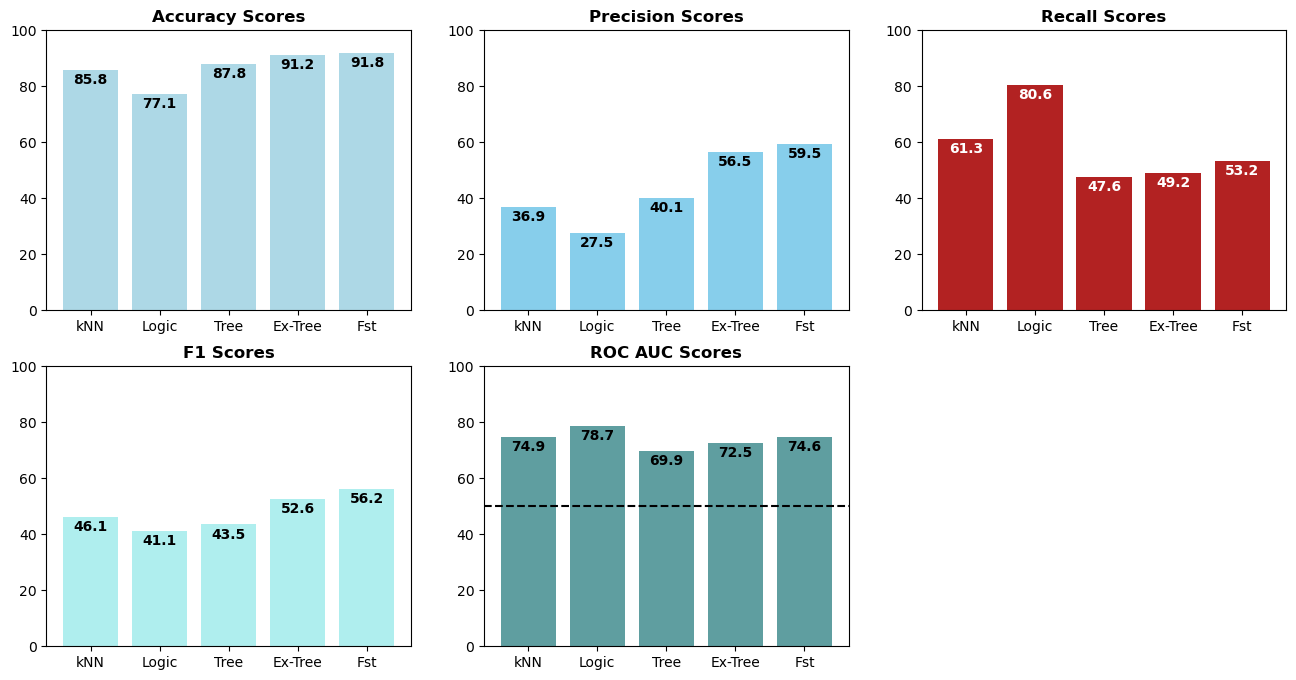

In [17]:
knn = KNeighborsClassifier(n_neighbors=5)
log_reg = LogisticRegression()
d_tree = DecisionTreeClassifier()
ex_tree = ExtraTreesClassifier(n_estimators=50)
rand_forest = RandomForestClassifier(n_estimators=50)

knn.fit(X_tr_smote_scaled, y_tr_smote)
log_reg.fit(X_tr_smote_scaled, y_tr_smote)
d_tree.fit(X_tr_smote, y_tr_smote)
ex_tree.fit(X_tr_smote, y_tr_smote)
rand_forest.fit(X_tr_smote, y_tr_smote)

# Test the models on validations.
model_dct = {
    "kNN": [knn, X_val_scaled, y_val],
    "Logic": [log_reg, X_val_scaled, y_val],
    "Tree": [d_tree, X_val, y_val],
    "Ex-Tree": [ex_tree, X_val, y_val],
    "Fst": [rand_forest, X_val, y_val]
}

model_score_visual(model_dct);

## Try Undersampling procedures

In [18]:
import imblearn.under_sampling

# specify desired data split - 30/70 here
ratio = {1: 30 , 0 : 70}

# randomly undersample negative samples: 
RUS = imblearn.under_sampling.RandomUnderSampler(sampling_strategy = ratio, random_state=31)

X_tr_us, y_tr_us = RUS.fit_resample(X_train, y_train)

X_tr_us_scaled = std_scale.fit_transform(X_tr_us)

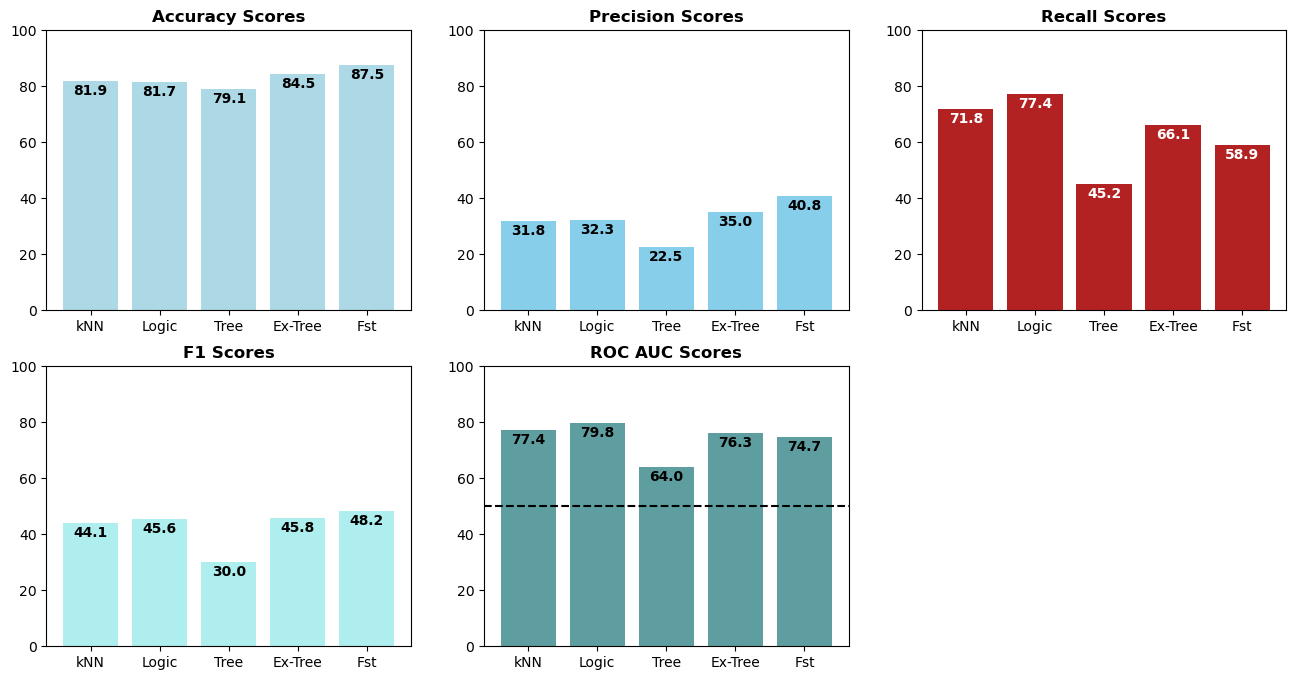

In [19]:
knn = KNeighborsClassifier(n_neighbors=5)
log_reg = LogisticRegression()
d_tree = DecisionTreeClassifier()
ex_tree = ExtraTreesClassifier(n_estimators=50)
rand_forest = RandomForestClassifier(n_estimators=50)

knn.fit(X_tr_us_scaled, y_tr_us)
log_reg.fit(X_tr_us_scaled, y_tr_us)
d_tree.fit(X_tr_us, y_tr_us)
ex_tree.fit(X_tr_us, y_tr_us)
rand_forest.fit(X_tr_us, y_tr_us)

# Test the models on validations.
model_dct = {
    "kNN": [knn, X_val_scaled, y_val],
    "Logic": [log_reg, X_val_scaled, y_val],
    "Tree": [d_tree, X_val, y_val],
    "Ex-Tree": [ex_tree, X_val, y_val],
    "Fst": [rand_forest, X_val, y_val]
}

model_score_visual(model_dct);

## Try Adjusting Class Weights

/Users/jamespeterman/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jamespeterman/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


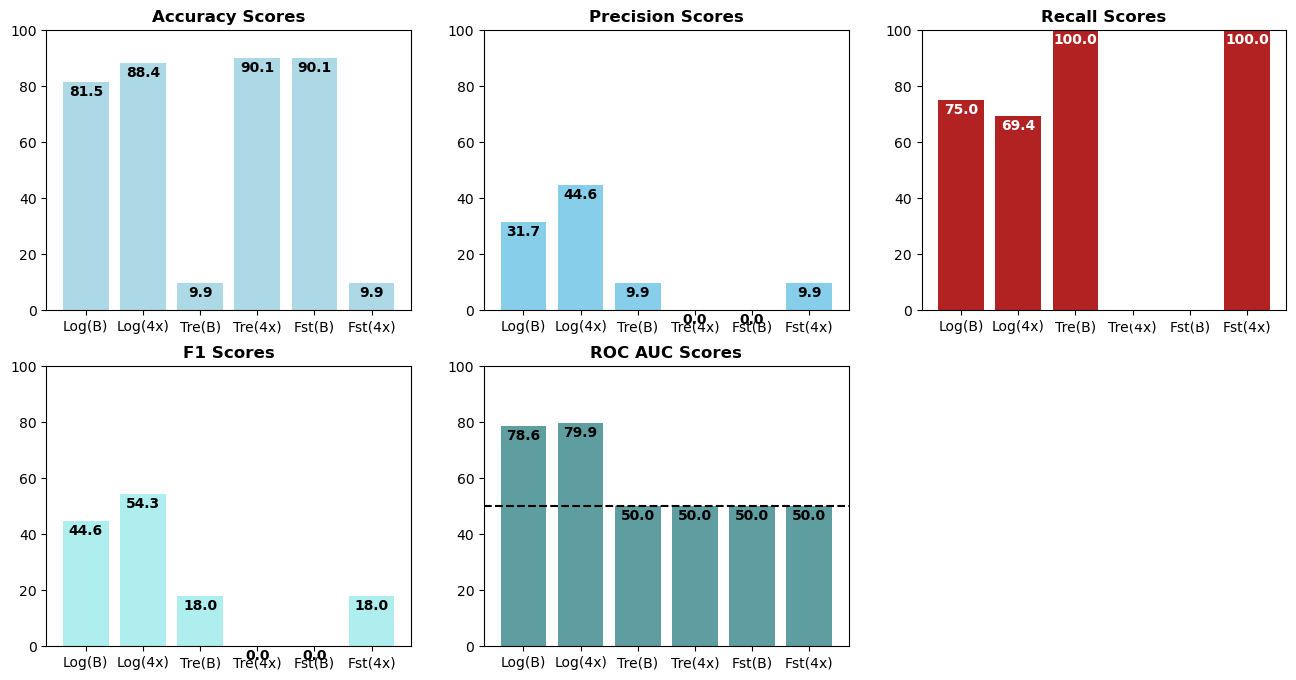

In [20]:
# Trying a balanced design and custom 4x weight.

# Not available for kNN. 
log_reg_balanced = LogisticRegression(class_weight="balanced")
log_reg_4x = LogisticRegression(class_weight={1: 4, 0:1})
d_tree_balanced = DecisionTreeClassifier(max_depth=8, class_weight="balanced")
d_tree_4x = DecisionTreeClassifier(max_depth=8, class_weight={1: 4, 0:1})
rand_forest_balanced = RandomForestClassifier(n_estimators=100, class_weight="balanced")
rand_forest_4x = RandomForestClassifier(n_estimators=100, class_weight={1: 4, 0:1})

log_reg_balanced.fit(X_train_scaled, y_train)
log_reg_4x.fit(X_train_scaled, y_train)
d_tree_balanced.fit(X_train_scaled, y_train)
d_tree_4x.fit(X_train_scaled, y_train)
rand_forest_balanced.fit(X_train_scaled, y_train)
rand_forest_4x.fit(X_train_scaled, y_train)

# Test the models on validations.
model_dct = {
    "Log(B)": [log_reg_balanced, X_val_scaled, y_val],
    "Log(4x)": [log_reg_4x, X_val_scaled, y_val],
    "Tre(B)": [d_tree_balanced, X_val, y_val],
    "Tre(4x)": [d_tree_4x, X_val, y_val],
    "Fst(B)": [rand_forest_balanced, X_val, y_val],
    "Fst(4x)": [rand_forest_4x, X_val, y_val]
}

model_score_visual(model_dct);

## Try adjusting decision thresholds.

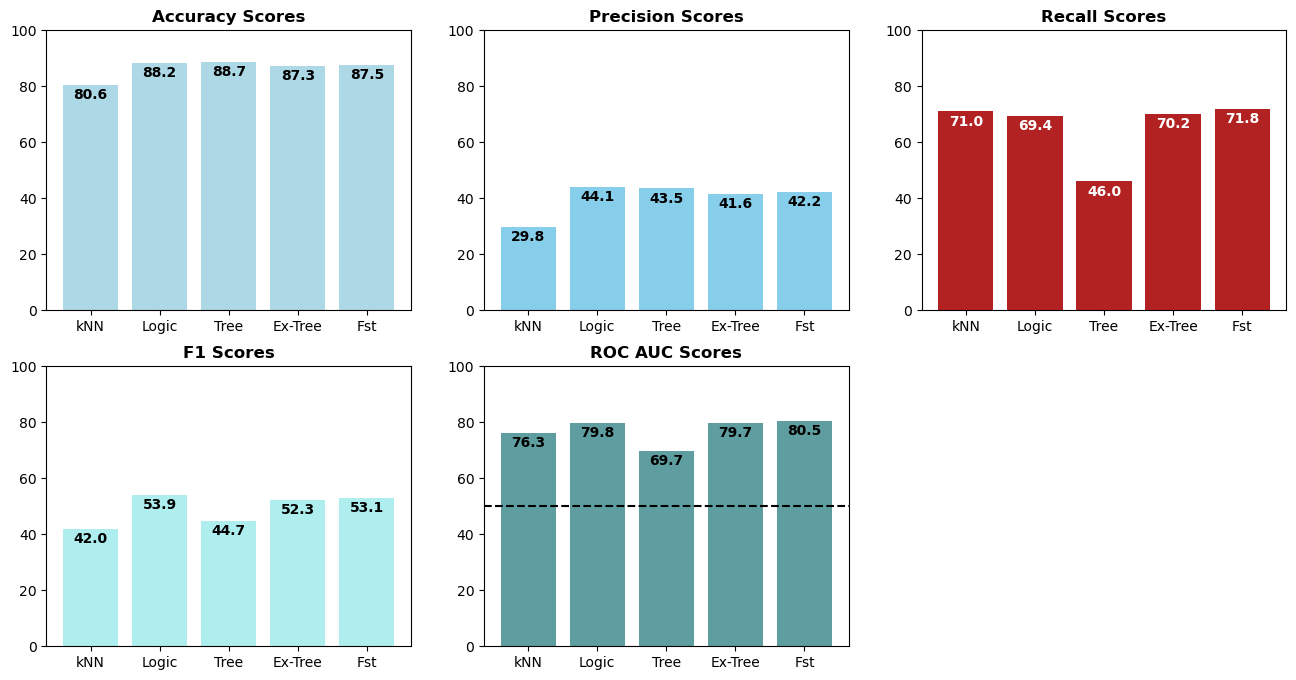

In [21]:
# First try without any oversampling

# Fit the models.
knn.fit(X_train_scaled, y_train)
log_reg.fit(X_train_scaled, y_train)
d_tree.fit(X_train, y_train)
ex_tree.fit(X_train, y_train)
rand_forest.fit(X_train, y_train)

# Test the models on validations.
model_dct = {
    "kNN": [knn, X_val_scaled, y_val, 0.2],
    "Logic": [log_reg, X_val_scaled, y_val, 0.2],
    "Tree": [d_tree, X_val, y_val, 0.2],
    "Ex-Tree": [ex_tree, X_val, y_val, 0.2],
    "Fst": [rand_forest, X_val, y_val, 0.2]
}

model_score_visual(model_dct);

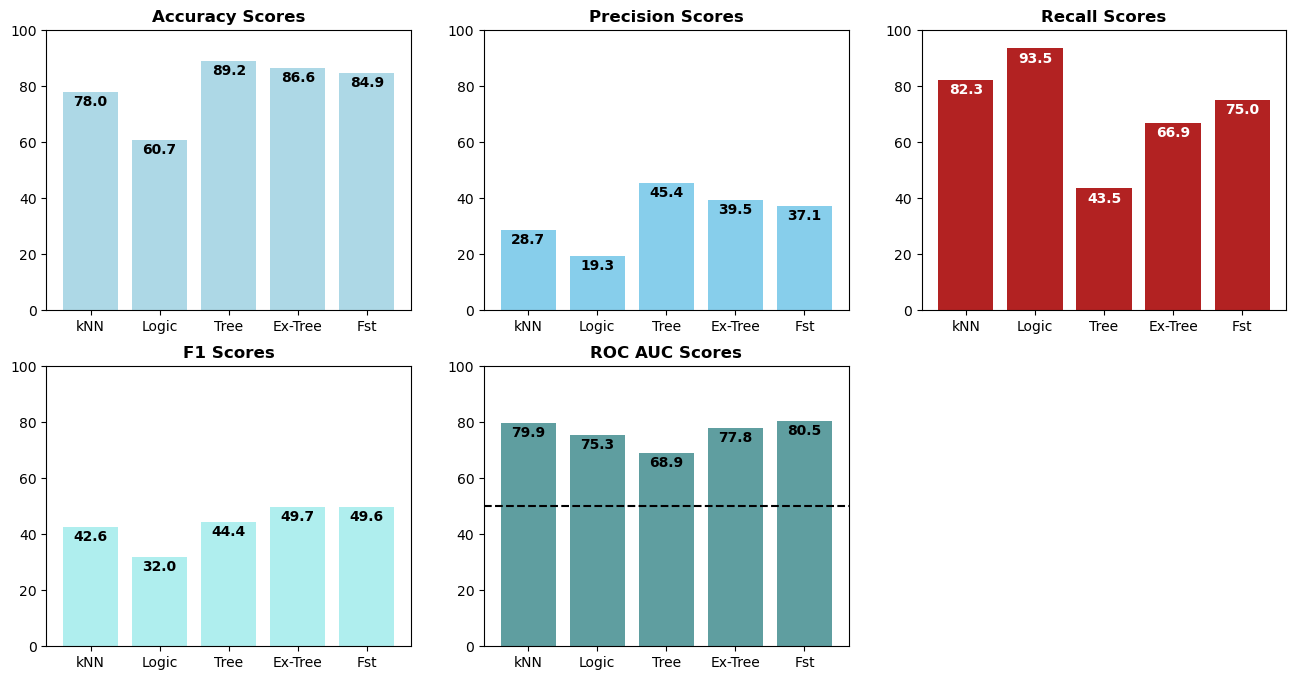

In [22]:
# Then try with the oversampling procedure (maybe the easier explanation of the above procedures).

# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {1 : n_pos * 5, 0 : n_neg} 

# randomly oversample positive samples: create 4x as many 
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=31) 
    
X_tr_rs, y_tr_rs = ROS.fit_resample(X_train, y_train)

X_tr_rs_scaled = std_scale.fit_transform(X_tr_rs)

# Train the models based on oversampled data.
knn = KNeighborsClassifier(n_neighbors=5)
log_reg = LogisticRegression()
d_tree = DecisionTreeClassifier()
ex_tree = ExtraTreesClassifier(n_estimators=50)
rand_forest = RandomForestClassifier(n_estimators=50)

knn.fit(X_tr_rs_scaled, y_tr_rs)
log_reg.fit(X_tr_rs_scaled, y_tr_rs)
d_tree.fit(X_tr_rs, y_tr_rs)
ex_tree.fit(X_tr_rs, y_tr_rs)
rand_forest.fit(X_tr_rs, y_tr_rs)

# Test the models on validations.
model_dct = {
    "kNN": [knn, X_val_scaled, y_val, 0.2],
    "Logic": [log_reg, X_val_scaled, y_val, 0.2],
    "Tree": [d_tree, X_val, y_val, 0.2],
    "Ex-Tree": [ex_tree, X_val, y_val, 0.2],
    "Fst": [rand_forest, X_val, y_val, 0.2]
}

model_score_visual(model_dct);


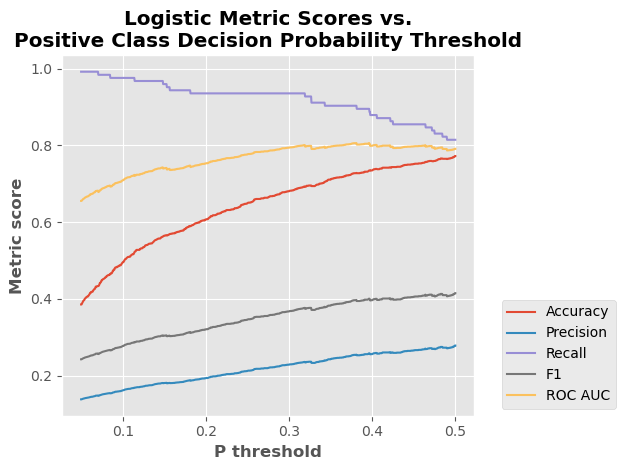

In [23]:
# Find the best decision threshold for the logistic regression.

thresh_ps = np.linspace(.05,.50,1000)
model_val_probs = log_reg.predict_proba(X_val_scaled)[:,1] # positive class probs
accuracy, precision, recall, f1, roc_auc = [], [], [], [], []

for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    accuracy.append(accuracy_score(y_val, model_val_labels))
    precision.append(precision_score(y_val, model_val_labels))
    recall.append(recall_score(y_val, model_val_labels))    
    f1.append(f1_score(y_val, model_val_labels))
    roc_auc.append(roc_auc_score(y_val, model_val_labels))
    
plt.style.use("ggplot")
plt.plot(thresh_ps, accuracy)
plt.plot(thresh_ps, precision)
plt.plot(thresh_ps, recall)
plt.plot(thresh_ps, f1)
plt.plot(thresh_ps, roc_auc)

plt.title("Logistic Metric Scores vs.\nPositive Class Decision Probability Threshold", weight="bold")
plt.legend(["Accuracy", "Precision", "Recall", "F1", "ROC AUC"], bbox_to_anchor=(1.05, 0), loc="lower left")
plt.xlabel("P threshold", weight="bold")
plt.ylabel("Metric score", weight="bold")

plt.tight_layout()
plt.savefig("./Figures/log_metrics_thresholds.jpg");

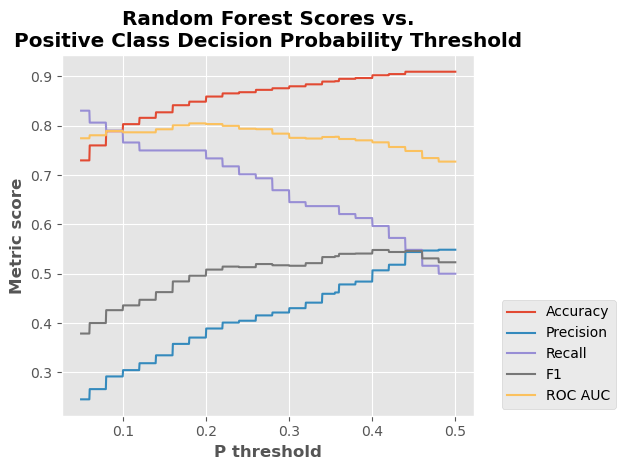

In [24]:
# Find the best decision threshold for the random forest.

thresh_ps = np.linspace(.05,.50,1000)
model_val_probs = rand_forest.predict_proba(X_val)[:,1] # positive class probs
accuracy, precision, recall, f1, roc_auc = [], [], [], [], []

for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    accuracy.append(accuracy_score(y_val, model_val_labels))
    precision.append(precision_score(y_val, model_val_labels))
    recall.append(recall_score(y_val, model_val_labels))    
    f1.append(f1_score(y_val, model_val_labels))
    roc_auc.append(roc_auc_score(y_val, model_val_labels))
    
plt.style.use("ggplot")
plt.plot(thresh_ps, accuracy)
plt.plot(thresh_ps, precision)
plt.plot(thresh_ps, recall)
plt.plot(thresh_ps, f1)
plt.plot(thresh_ps, roc_auc)

plt.title("Random Forest Scores vs.\nPositive Class Decision Probability Threshold", weight="bold")
plt.legend(["Accuracy", "Precision", "Recall", "F1", "ROC AUC"], bbox_to_anchor=(1.05, 0), loc="lower left")
plt.xlabel("P threshold", weight="bold")
plt.ylabel("Metric score", weight="bold")

plt.tight_layout()
# plt.savefig("./Figures/rand_for_metrics_thresholds.jpg");

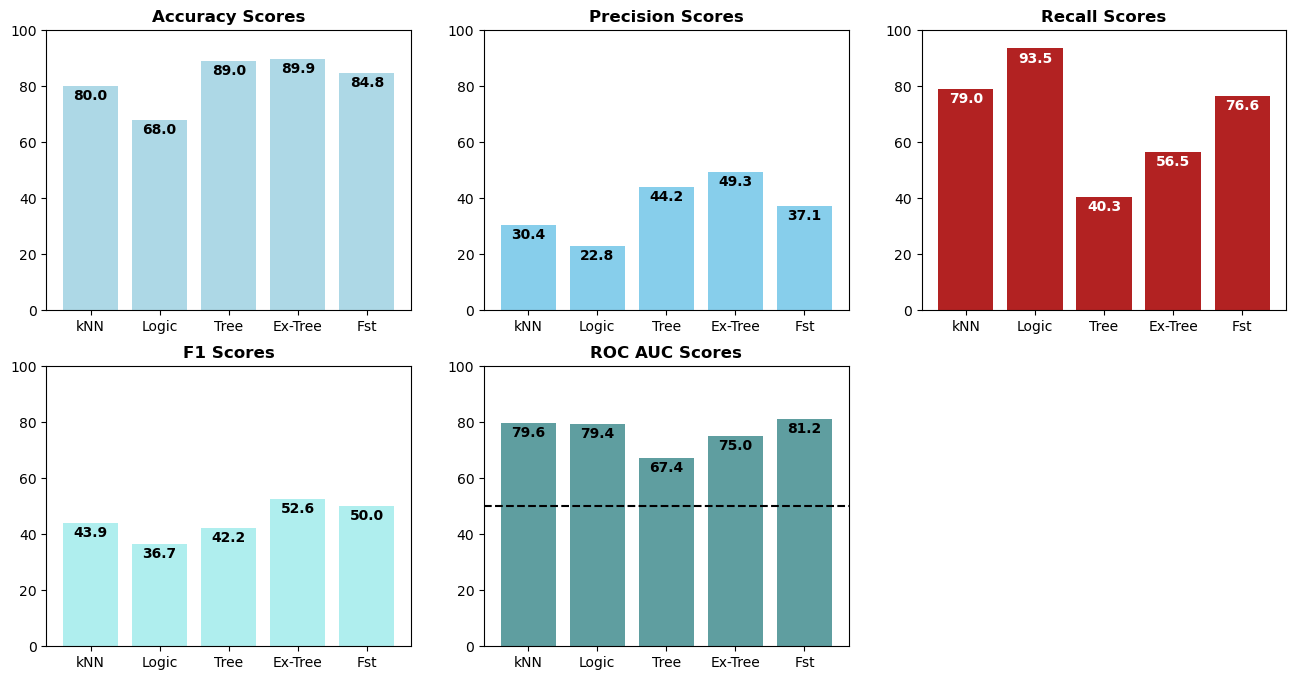

In [25]:
# Based on above, it seems 0.3 is a good trade-off in terms of recall and ROC AUC for the logistic
# and 0.2 for random forest (not super interested in other models so sticking with 0.3 for them).

# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {1 : n_pos * 5, 0 : n_neg} 

# randomly oversample positive samples: create 4x as many 
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=31) 
    
X_tr_rs, y_tr_rs = ROS.fit_resample(X_train, y_train)

X_tr_rs_scaled = std_scale.fit_transform(X_tr_rs)

# Train the models based on oversampled data.
knn = KNeighborsClassifier(n_neighbors=5)
log_reg = LogisticRegression()
d_tree = DecisionTreeClassifier()
ex_tree = ExtraTreesClassifier(n_estimators=50)
rand_forest = RandomForestClassifier(n_estimators=50)

knn.fit(X_tr_rs_scaled, y_tr_rs)
log_reg.fit(X_tr_rs_scaled, y_tr_rs)
d_tree.fit(X_tr_rs, y_tr_rs)
ex_tree.fit(X_tr_rs, y_tr_rs)
rand_forest.fit(X_tr_rs, y_tr_rs)

# Test the models on validations.
model_dct = {
    "kNN": [knn, X_val_scaled, y_val, 0.3],
    "Logic": [log_reg, X_val_scaled, y_val, 0.3],
    "Tree": [d_tree, X_val, y_val, 0.3],
    "Ex-Tree": [ex_tree, X_val, y_val, 0.3],
    "Fst": [rand_forest, X_val, y_val, 0.2]
}

model_score_visual(model_dct);


## Try XG Boost

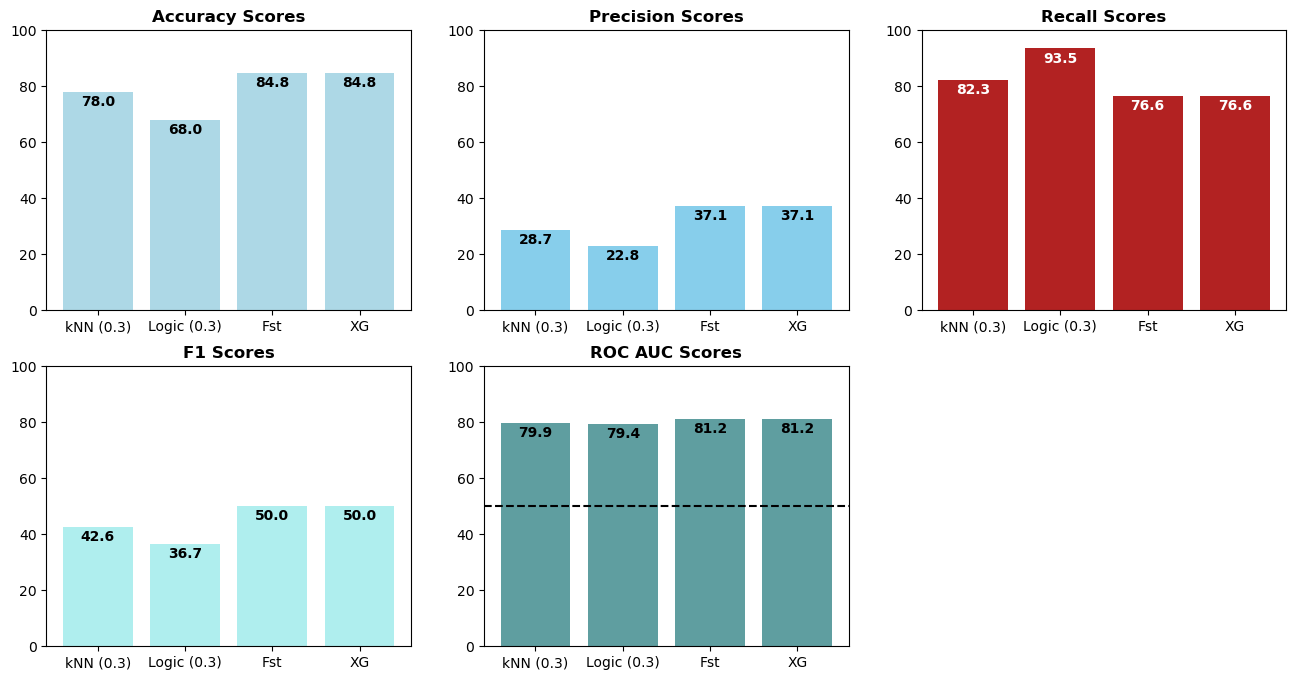

In [26]:
gbm = xgb.XGBClassifier(
    n_estimators=30000,
    max_depth=4,
    objective='binary:logistic', 
    learning_rate=.05, 
    subsample=.8,
    min_child_weight=3,
    colsample_bytree=.8,
    # Turns off warning as XGBClassifier uses deprecated functions of scikit-learn package
    use_label_encoder =False,
    # Using ratio of 0 to 1 class for scaling since there's an imbalance.
    scale_pos_weight = (sum(y_train == 0) / sum(y_train == 1)))

eval_set=[(X_train,y_train),(X_val,y_val)]
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='aucpr', # evaluation metric that more targets recall/precision.
                    early_stopping_rounds=50,
                    verbose=False
                   )

model_dct = {
    "kNN (0.3)": [knn, X_val_scaled, y_val, 0.2],
    "Logic (0.3)": [log_reg, X_val_scaled, y_val, 0.3],
    "Fst": [rand_forest, X_val, y_val, 0.2],
    "XG": [gbm, X_val, y_val]}

model_score_visual(model_dct);

## Try ensembling methods.

/Users/jamespeterman/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


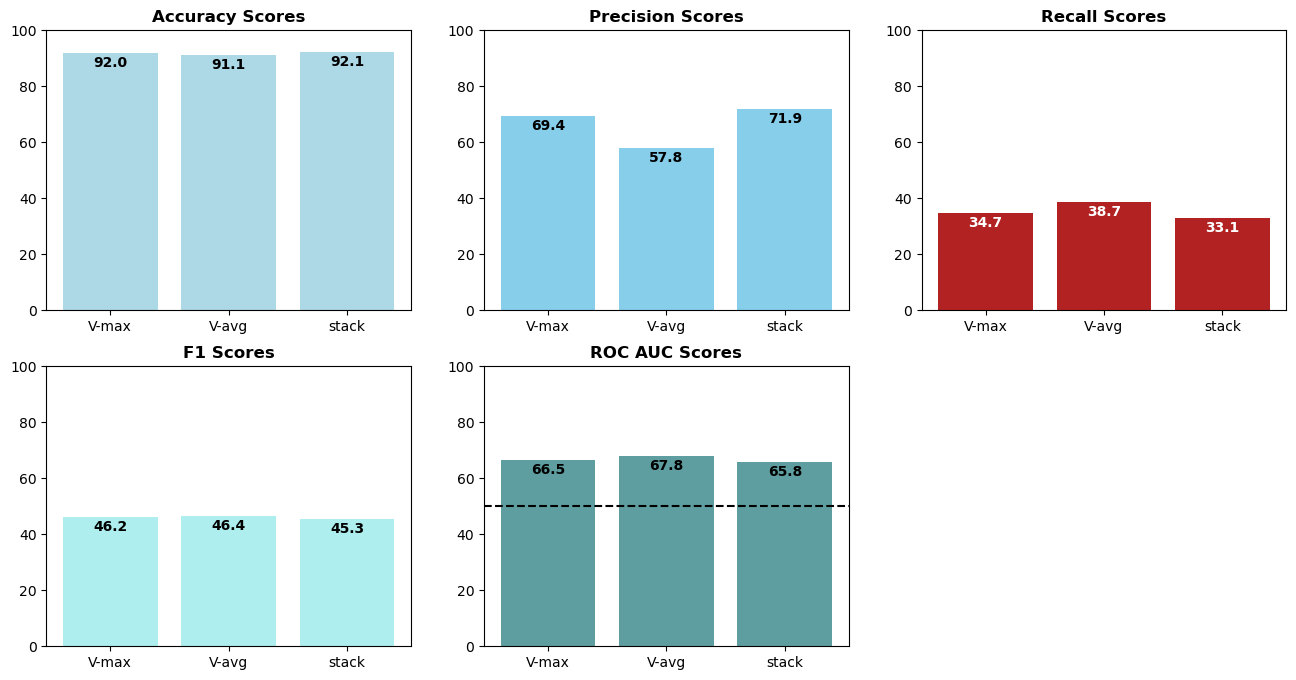

In [27]:
# INCLUDED only kNN, Logistic, and Decision Tree.

# Train the models.
knn = KNeighborsClassifier(n_neighbors=5)
log_reg = LogisticRegression()
d_tree = DecisionTreeClassifier()

# Have to pass a list of tuples as such for voting method.
model_lst = [("knn", knn), ("log_reg", log_reg), ("d_tree", d_tree)]

# Pass in the models this way for stacking method:
model_vars = [knn, log_reg, d_tree, rand_forest]

# Train the models.
vc_max = VotingClassifier(estimators=model_lst,
                                    voting='hard', # max voting
                                    n_jobs=-1)
vc_avg = VotingClassifier(estimators=model_lst,
                                    voting='soft', # avg voting
                                    n_jobs=-1)
stacked = StackingClassifier(
    classifiers=model_vars, meta_classifier=LogisticRegression(), use_probas=False)


# Fit the models.
vc_max.fit(X_train, y_train)
vc_avg.fit(X_train, y_train)
stacked.fit(X_train, y_train)

# Test the models on validations.
model_dct = {"V-max": [vc_max, X_val, y_val],
            "V-avg": [vc_avg, X_val, y_val],
            "stack": [stacked, X_val, y_val]}

model_score_visual(model_dct);

## Try Naive Bayes (ensembling the models).

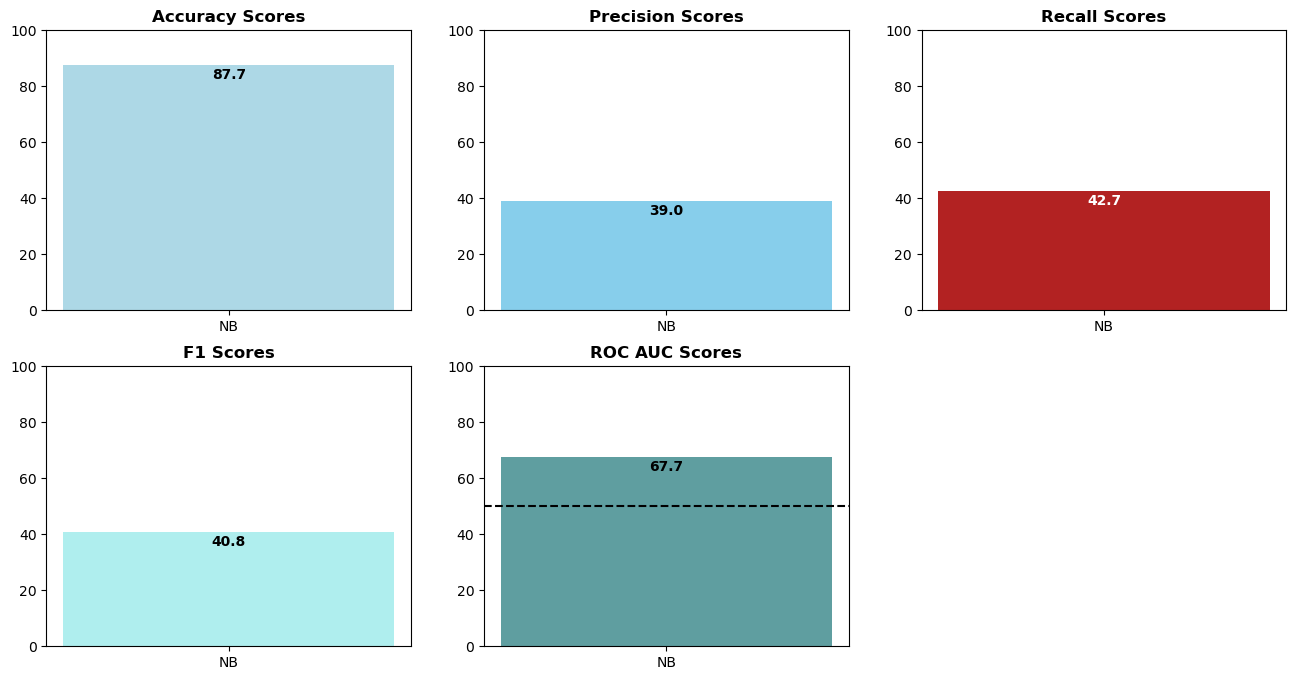

In [28]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB

# First have to split the features into those that are categorical and those that are numerical.
X_num = df[["ageattest", "bmi", "resting_hr", "resting_sbp"]]

X_cat = df[["Gender", "PhysInactive", "BetaMed",
       "Diabetes", "COPD", "ANYCVD", "Asthma"]]
y = df["low_fitness"]

X_train_val_num, X_test_num, y_train_val_num, y_test_num = train_test_split(X_num, y, test_size=0.2, random_state=13)
X_train_num, X_val_num, y_train_num, y_val_num = train_test_split(X_train_val_num, y_train_val, test_size=.25, random_state=13)

X_train_val_cat, X_test_cat, y_train_val_cat, y_test_cat = train_test_split(X_cat, y, test_size=0.2, random_state=13)
X_train_cat, X_val_cat, y_train_cat, y_val_cat = train_test_split(X_train_val_cat, y_train_val, test_size=.25, random_state=13)


X_train_val_cat = pd.get_dummies(X_train_val_cat, drop_first=True)
X_train_cat = pd.get_dummies(X_train_cat, drop_first=True)
X_val_cat = pd.get_dummies(X_val_cat, drop_first=True)
X_test_cat = pd.get_dummies(X_test_cat, drop_first=True)

# Numeric gets fit on Gaussian.
nb_g = GaussianNB()
nb_g.fit(X_train_num, y_train)

# Categorical gets fit on multinomial.
nb_m = MultinomialNB()
nb_m.fit(X_train_cat, y_train)

# Predict the probabilities from each.
# At this point I'm trying the validation dataset.
gaussian_probas = nb_g.predict_proba(X_val_num)
multinomial_probas = nb_m.predict_proba(X_val_cat)

# Then use the probabilities as new features and then fit the model.
X_train_new = np.hstack((multinomial_probas, gaussian_probas))
nb_g_final = GaussianNB()
nb_g_final.fit(X_train_new, y_val)

# Test the models on training data.
model_dct = {"NB": [nb_g_final, X_train_new, y_val]}

model_score_visual(model_dct);

## Present the metrics from my "favorite" models.

Logistic done a few ways, random forest, and XG Boost.

In [29]:
# This time, train using the train+validation datasets.

# These are the final features to be used:

X = df[["ageattest", "Gender", "height", "weight",
        "PhysInactive", 
        "BetaMed", "hypertension",
       "Diabetes", "COPD", "ANYCVD", "Asthma"]]
y = df["low_fitness"]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
# Still need validation for XG Boost model.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=13)

X_train_val = pd.get_dummies(X_train_val, drop_first=True)
X_train = pd.get_dummies(X_train, drop_first=True)
X_val = pd.get_dummies(X_val, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

std_scale = StandardScaler()
X_train_val_scaled = std_scale.fit_transform(X_train_val)
X_test_scaled = std_scale.fit_transform(X_test)

# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_train_val == 1)
n_neg = np.sum(y_train_val == 0)
ratio = {1 : n_pos * 5, 0 : n_neg} 
# randomly oversample positive samples: create 4x as many 
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=31) 
X_tr_val_rs, y_tr_val_rs = ROS.fit_resample(X_train_val, y_train_val)
X_tr_val_rs_scaled = std_scale.fit_transform(X_tr_val_rs)


In [30]:
# Train the models. 

log_reg = LogisticRegression()
log_reg_os = LogisticRegression()
rand_forest = RandomForestClassifier(n_estimators=50)

log_reg.fit(X_train_val_scaled, y_train_val)
log_reg_os.fit(X_tr_val_rs_scaled, y_tr_val_rs)
rand_forest.fit(X_tr_val_rs, y_tr_val_rs)

gbm = xgb.XGBClassifier(
    n_estimators=30000,
    max_depth=4,
    objective='binary:logistic', 
    learning_rate=.05, 
    subsample=.8,
    min_child_weight=3,
    colsample_bytree=.8,
    # Turns off warning as XGBClassifier uses deprecated functions of scikit-learn package
    use_label_encoder =False,
    # Using ratio of 0 to 1 class for scaling since there's an imbalance.
    scale_pos_weight = (sum(y_train_val == 0) / sum(y_train_val == 1)))

eval_set=[(X_train,y_train),(X_val,y_val)]
fit_model = gbm.fit( 
                    X_train_val, y_train_val, 
                    eval_set=eval_set,
                    eval_metric='aucpr', # evaluation metric that more targets recall/precision.
                    early_stopping_rounds=50,
                    verbose=False
                   )

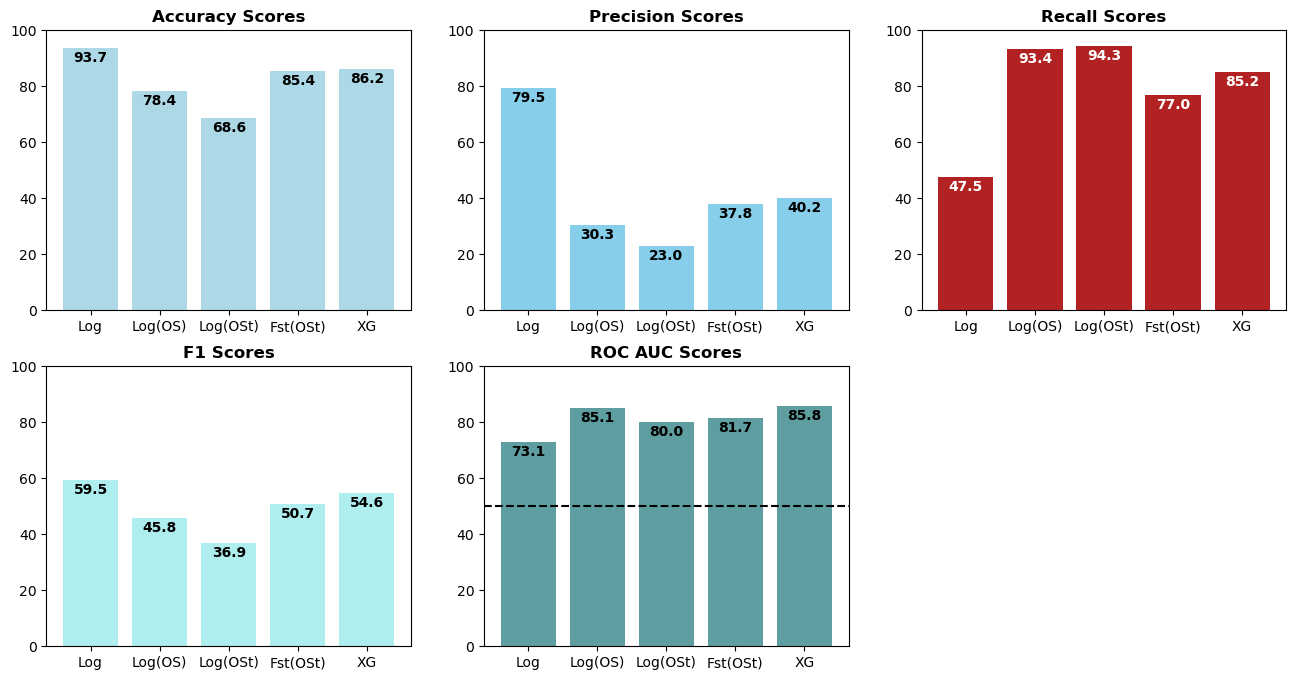

In [31]:
# This time, show performance on the TEST data.

model_dct = {
    "Log": [log_reg, X_test_scaled, y_test],
    "Log(OS)": [log_reg_os, X_test_scaled, y_test],
    "Log(OSt)": [log_reg_os, X_test_scaled, y_test, 0.3],
    "Fst(OSt)": [rand_forest, X_test, y_test, 0.2],
    "XG": [gbm, X_test, y_test]}

model_score_visual(model_dct);

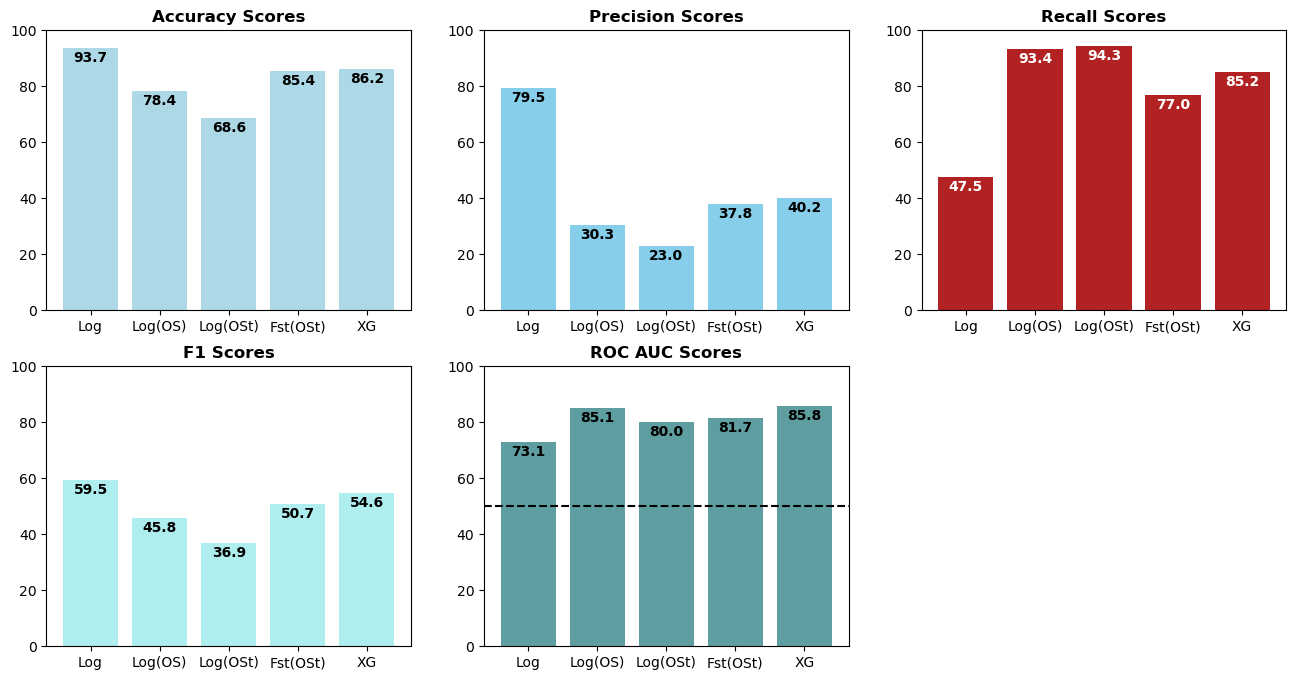

In [32]:
# Save the above figure.

fig = model_score_visual(model_dct)
fig.savefig("./Figures/summary_metrics.jpg");

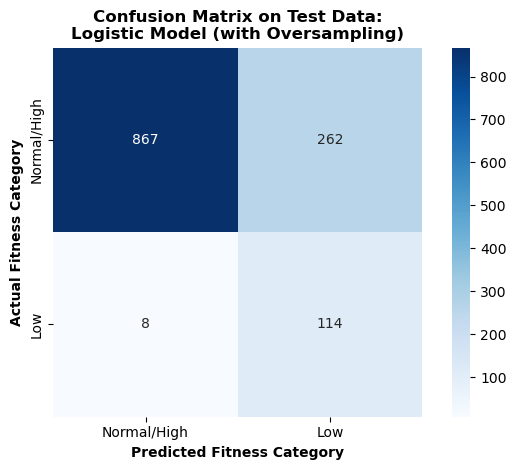

In [33]:
# Create a confusion matrix for best model (the logistic model WITH REGULAR decision threshold).

y_predict = (log_reg_os.predict_proba(X_test_scaled)[:,1] > 0.5) 

fraud_confusion = confusion_matrix(y_test, y_predict)
sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
       xticklabels=["Normal/High", "Low"],
       yticklabels=["Normal/High", "Low"]);
plt.xlabel('Predicted Fitness Category', weight="bold")
plt.ylabel('Actual Fitness Category', weight="bold")
plt.title("Confusion Matrix on Test Data:\nLogistic Model (with Oversampling)", weight="bold")

plt.tight_layout()
plt.savefig("./Figures/model_confusion.jpg");

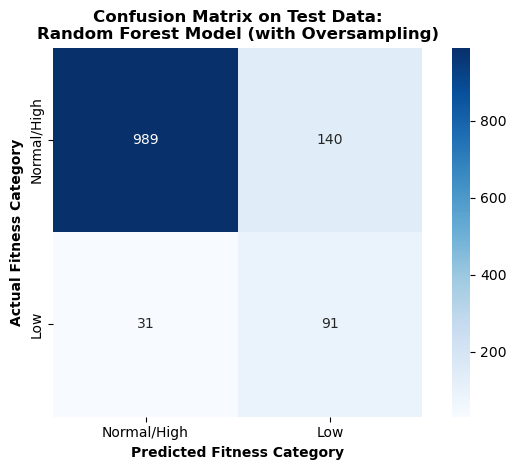

In [34]:
# Out of curiosity, create confusion matrix for random forest model.

y_predict = (rand_forest.predict_proba(X_test)[:,1] > 0.2) 

fraud_confusion = confusion_matrix(y_test, y_predict)
sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
       xticklabels=["Normal/High", "Low"],
       yticklabels=["Normal/High", "Low"]);
plt.xlabel('Predicted Fitness Category', weight="bold")
plt.ylabel('Actual Fitness Category', weight="bold")
plt.title("Confusion Matrix on Test Data:\nRandom Forest Model (with Oversampling)", weight="bold")

plt.tight_layout()
# plt.savefig("./Figures/_rand_for_model_confusion.jpg");

In [35]:
for i, n in enumerate(X.columns):
    print(f"{n}: {log_reg_os.coef_[0][i]:.1f}")

ageattest: 1.3
Gender: -0.5
height: 1.3
weight: 0.6
PhysInactive: 0.3
BetaMed: -0.1
hypertension: 0.2
Diabetes: 0.0
COPD: 0.5
ANYCVD: 0.0
Asthma: -1.3


In [36]:
clean_labels = ["Age", "Sex (Male)", "Height", "Weight", "Physically Inactive",
                     "Beta Blocker Med", "Hypertension", "Diabetes", "COPD", "CVD", "Asthma"]
coef_lst = log_reg_os.coef_[0]

y_lst, x_lst = list(zip(*[(n,x) for n, x in sorted(zip(coef_lst, clean_labels), key=(lambda pair: abs(pair[0])))]))

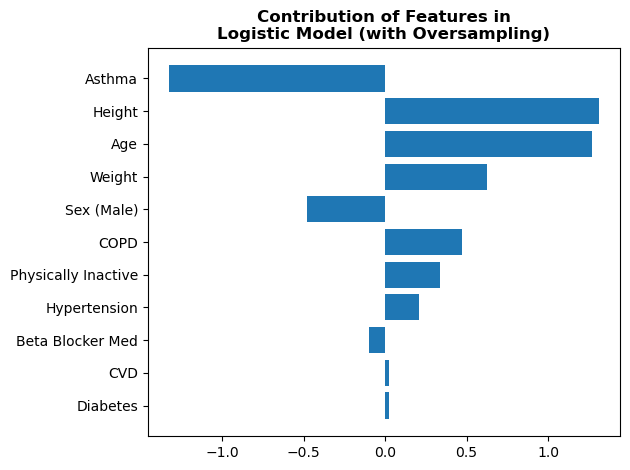

In [37]:
plt.barh(x_lst, y_lst)
plt.title("Contribution of Features in\nLogistic Model (with Oversampling)", weight="bold")

plt.tight_layout()
plt.savefig("./Figures/model_features.jpg");
